In [3]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

plt.rcParams["font.size"] = 18

cmap = {
    "EKF-IW": "crimson",
    "WLF-IMQ": "dodgerblue",
    "EKF": "lightseagreen",
    "WLF-MD": "gold", # TODO: make more o-paco
    "OGD": "blueviolet",
    "EKF-B": "darkorange",
}

In [33]:
path_base = "./results"
dataset_name = "naval-propulsion-plant"
# dataset_name = "yacht"
experiment_names = [f for f in os.listdir(path_base) if ("-target" in f) and ("p-error" in f) and (dataset_name in f)]
sorted(experiment_names)

['naval-propulsion-plant-target-p-error00.pkl',
 'naval-propulsion-plant-target-p-error05.pkl',
 'naval-propulsion-plant-target-p-error10.pkl',
 'naval-propulsion-plant-target-p-error15.pkl',
 'naval-propulsion-plant-target-p-error20.pkl',
 'naval-propulsion-plant-target-p-error25.pkl',
 'naval-propulsion-plant-target-p-error30.pkl',
 'naval-propulsion-plant-target-p-error35.pkl',
 'naval-propulsion-plant-target-p-error40.pkl',
 'naval-propulsion-plant-target-p-error45.pkl']

In [34]:
df_all = []
for file in experiment_names:
    with open(os.path.join(path_base, file), "rb") as f:
        res = pickle.load(f)
    
    errors = res["methods"]
    for method in errors:
        part = np.sqrt(errors[method].median(axis=0))
        part.name  = "RMedSE"
        part = pd.DataFrame(part)
        part["method"] = method
        part["p_error"] = res["config"]["p_error"]
        
        df_all.append(part)
df_all = pd.concat(df_all, axis=0)

In [35]:
df_all.head()

,RMedSE,method,p_error
0,0.222120,WLF-IMQ,0.25
1,0.226709,WLF-IMQ,0.25
2,0.227162,WLF-IMQ,0.25
3,0.233560,WLF-IMQ,0.25
4,0.228612,WLF-IMQ,0.25


In [36]:
void_methods = ["EKF", "OGD"]

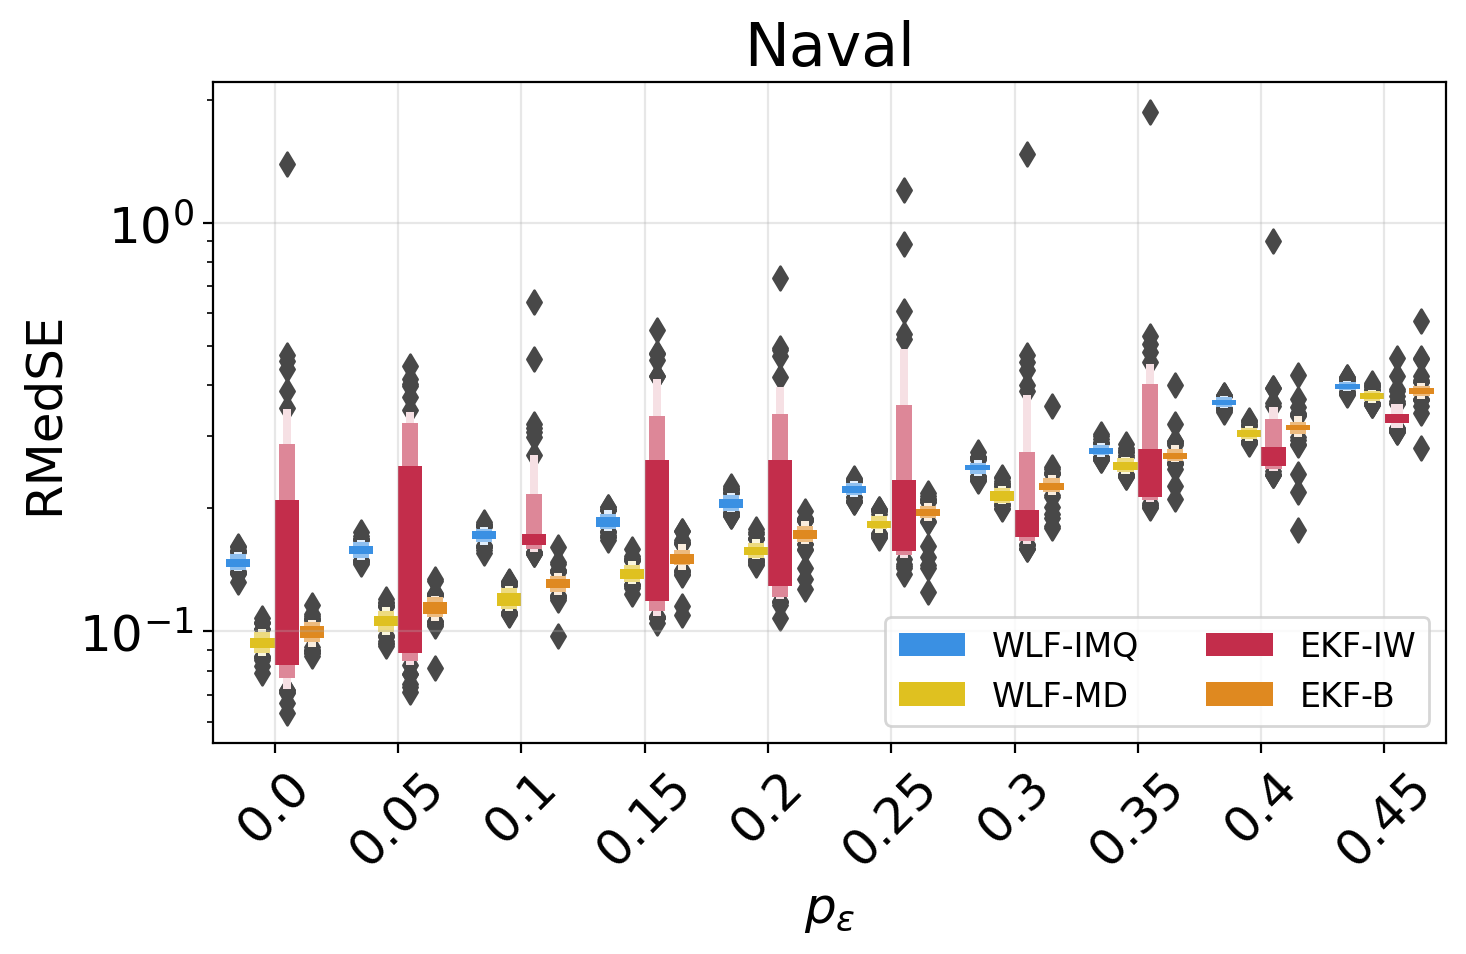

In [43]:
methods = sorted(df_all.method.unique())
fig, ax = plt.subplots(figsize=(6.4 * 1.2, 4.8))
sns.boxenplot(
    x="p_error", hue="method", y="RMedSE",
    data=(
        df_all
        # df_all.assign(p_error = np.clip(df_all["RMedSE"], 0.0, 1.0))
        .query("RMedSE <= 2.0")
        .query("method not in @void_methods")
        .query("p_error < 0.5")
    ),
    palette=cmap,
    linewidth=0,
    scale="linear",
    # hue_order=methods[2:]
)
plt.yscale("log")
plt.xticks(rotation=45)
plt.xlabel("$p_\epsilon$")
plt.legend(loc="lower right", fontsize=12, ncol=2)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.title(dataset_name.split("-")[0].capitalize())
plt.savefig(f"./figures/{dataset_name}-corrosion.png", dpi=300)

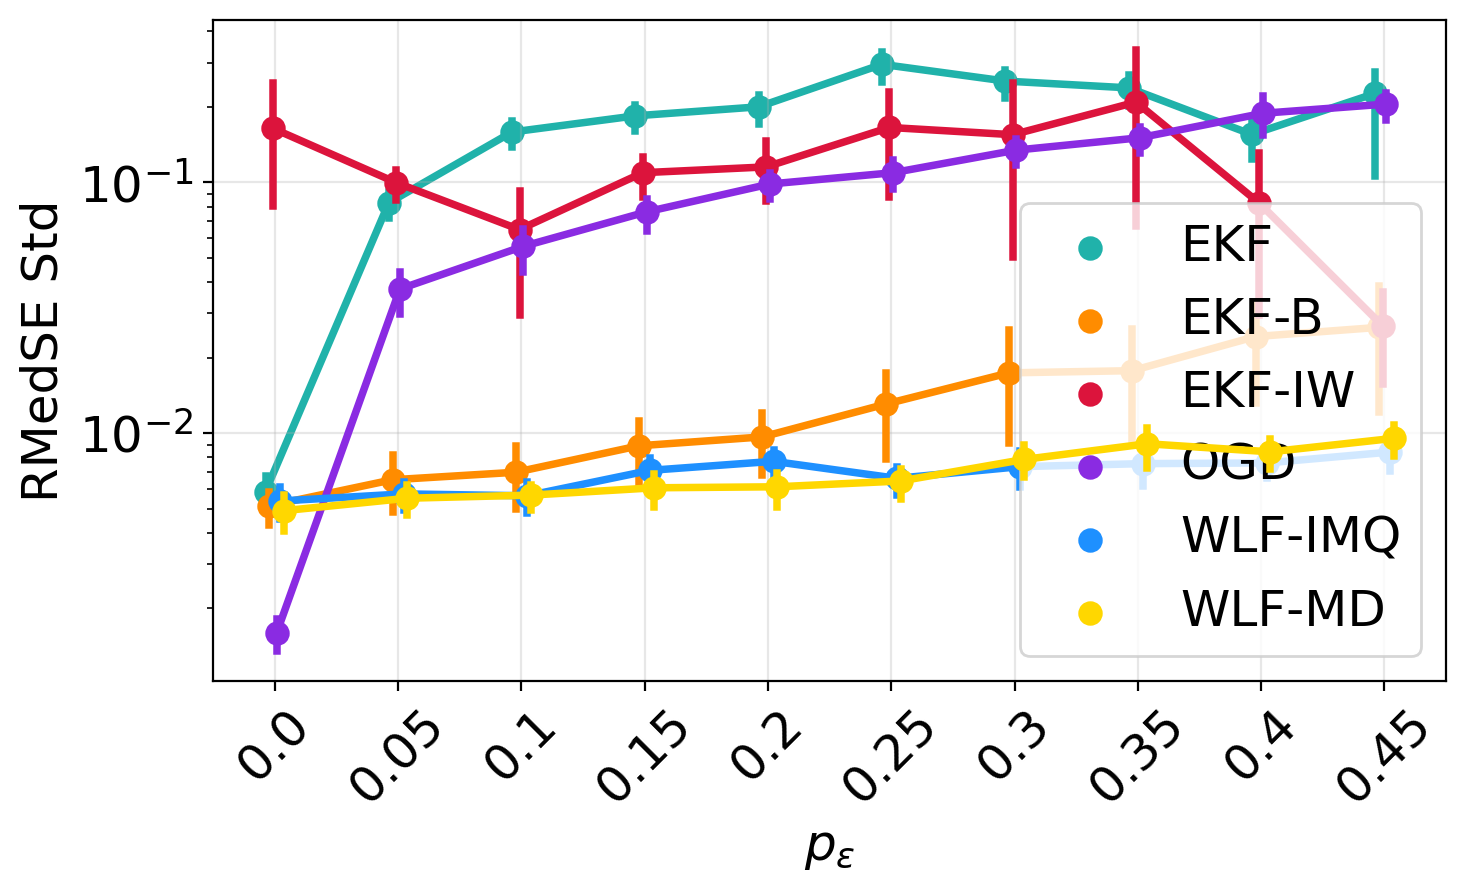

In [38]:
methods = sorted(df_all.method.unique())
fig, ax = plt.subplots(figsize=(6.4 * 1.2, 4.8))
sns.pointplot(
    x="p_error", hue="method", y="RMedSE",
    data=(
        df_all
        .query("p_error < 0.5")
        .query("RMedSE <= 2.0")
    ),
    palette=cmap,
    hue_order=methods,
    estimator="std",
    dodge=True
)
plt.yscale("log")
plt.xticks(rotation=45)
plt.xlabel("$p_\epsilon$")
plt.ylabel("RMedSE Std")
plt.legend(ncol=1)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f"./figures/{dataset_name}-corrosion-std-all.png", dpi=300)

## New ablation

In [123]:
filename = "./results/regression-stress-kin8nm.pkl"
with open(filename, "rb") as f:
    res = pickle.load(f)
errs = res["p_errors_collection"]
dataset_name = res["config"]["metadata"]["dataset-name"]

In [124]:
df_errs = []
for p in errs:
    errs_p = pd.DataFrame(jax.tree_map(lambda x: np.sqrt(np.median(x ** 2, axis=1)), errs[p]))
    errs_p = errs_p.reset_index().rename({"index": "run"}, axis=1)
    errs_p = errs_p.melt("run")
    errs_p["p_err"] = p
    df_errs.append(errs_p)
    
df_errs = pd.concat(df_errs)
df_errs["variable"] = df_errs["variable"].str.replace("KF", "EKF")

/tmp/ipykernel_1501028/3236529364.py:3: RuntimeWarning: overflow encountered in square
  errs_p = pd.DataFrame(jax.tree_map(lambda x: np.sqrt(np.median(x ** 2, axis=1)), errs[p]))
/tmp/ipykernel_1501028/3236529364.py:3: RuntimeWarning: overflow encountered in square
  errs_p = pd.DataFrame(jax.tree_map(lambda x: np.sqrt(np.median(x ** 2, axis=1)), errs[p]))
/tmp/ipykernel_1501028/3236529364.py:3: RuntimeWarning: overflow encountered in square
  errs_p = pd.DataFrame(jax.tree_map(lambda x: np.sqrt(np.median(x ** 2, axis=1)), errs[p]))
/tmp/ipykernel_1501028/3236529364.py:3: RuntimeWarning: overflow encountered in square
  errs_p = pd.DataFrame(jax.tree_map(lambda x: np.sqrt(np.median(x ** 2, axis=1)), errs[p]))
/tmp/ipykernel_1501028/3236529364.py:3: RuntimeWarning: overflow encountered in square
  errs_p = pd.DataFrame(jax.tree_map(lambda x: np.sqrt(np.median(x ** 2, axis=1)), errs[p]))
/tmp/ipykernel_1501028/3236529364.py:3: RuntimeWarning: overflow encountered in square
  errs_p = pd

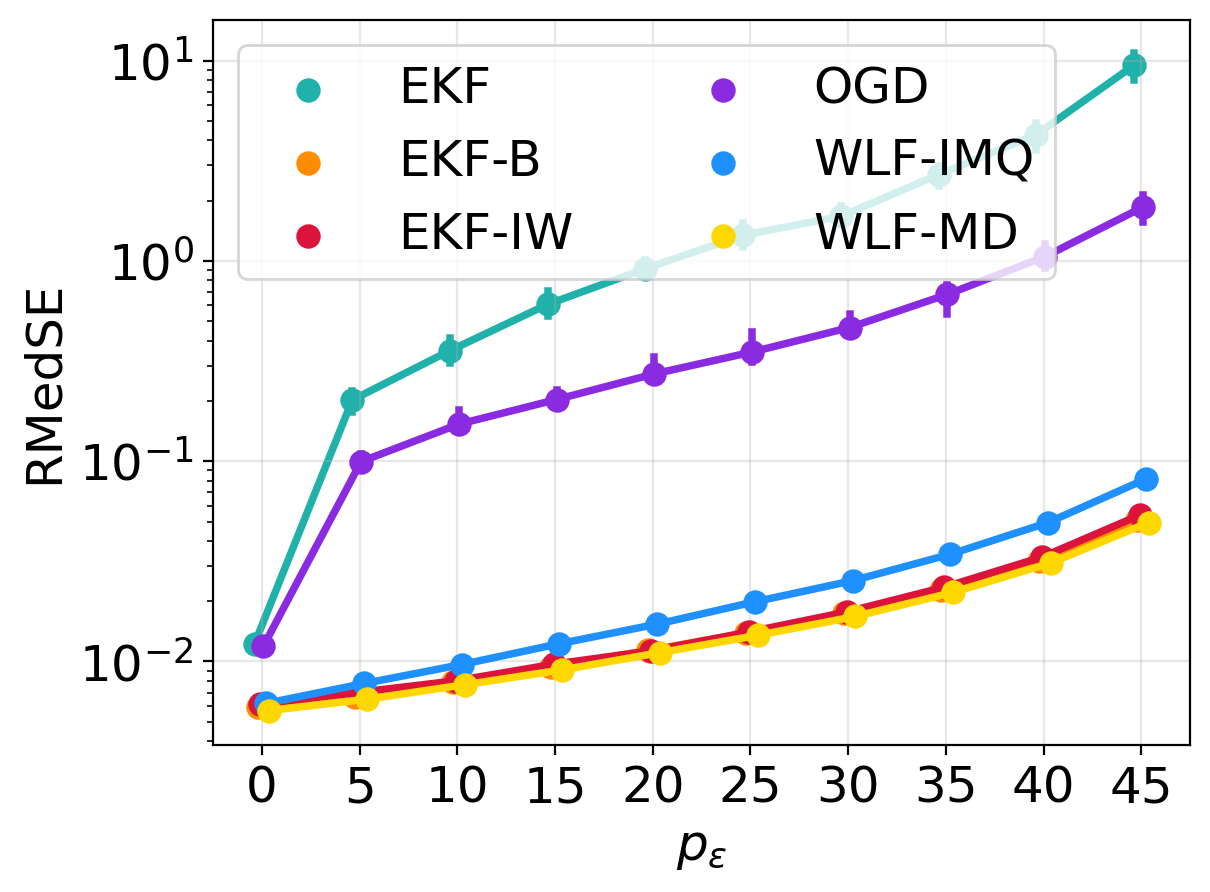

In [132]:
sns.pointplot(
    x="p_err", y="value", hue="variable",
    data=df_errs,
    estimator="median",
    palette=cmap,
    dodge=True
)
plt.legend(ncol=2)
plt.ylabel("RMedSE")
plt.xlabel("$p_\epsilon$")
plt.yscale("log")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f"./figures/{dataset_name}-corrosion.png", dpi=300)

In [113]:
def qlow(x): return np.percentile(x, 0.05)
def qhigh(x): return np.percentile(x, 0.95)
funcs = [qlow, qhigh]

df_errs.pivot_table(index="p_err", columns="variable", values="value", aggfunc=funcs)

qlow                                                    \
variable       EKF     EKF-B    EKF-IW       OGD   WLF-IMQ    WLF-MD   
p_err                                                                  
0         0.010941  0.004790  0.004869  0.010409  0.005039  0.004645   
5         0.072246  0.005674       NaN  0.047530  0.006062  0.005325   
10        0.120072  0.006644  0.006256  0.064656  0.007727  0.006013   
15        0.179524  0.007815  0.007600  0.076054  0.009991  0.007501   
20        0.318863  0.009533  0.009187  0.099058  0.013100  0.009025   
25        0.414646  0.011923  0.011053  0.107582  0.016943  0.010871   
30        0.505498  0.014798  0.014070  0.165825  0.020145  0.013981   
35        1.009361  0.019037       NaN  0.211168  0.028275  0.018444   
40        1.044484  0.025710  0.025568  0.285635  0.038120  0.025034   
45        1.801638  0.040415  0.041719  0.461284  0.062401  0.038719   

             qhigh                                                    
variable       EKF     EKF-B    EKF-IW       OGD   WLF-IMQ    WLF-MD  
p_err                                                                 
0         0.011060  0.004896  0.004966  0.010422  0.005251  0.004742  
5         0.073866  0.005796       NaN  0.048669  0.006528  0.005385  
10        0.141452  0.006809  0.006509  0.077091  0.007925  0.006313  
15        0.203032  0.007950  0.007843  0.081632  0.010115  0.007585  
20        0.329798  0.009680  0.009480  0.103656  0.013200  0.009041  
25        0.438100  0.011948  0.011348  0.108340  0.016950  0.011294  
30        0.539327  0.014896  0.014603  0.191206  0.021267  0.014247  
35        1.028143  0.019291       NaN  0.215875  0.029353  0.018572  
40        1.513566  0.026264  0.025829  0.334055  0.038671  0.025226  
45        2.483082  0.040621  0.042080  0.506373  0.063070  0.039140